### Building a neural network to predict available soil water

The model will be built as a univariate LSTM neural network, based only on the available soil water values. This model was chosen because of its strength in handling data that is dependant on retaining its sequence

In [9]:
# import the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

Set the random seed for reproducibility

In [10]:
np.random.seed(7)

The data from site 524 is imported but only the single column that we need. By setting a new variable as just the values we end up with a numpy array.
The values are standardized between 0 and 1 using the MinMaxScaler.

In [11]:
dataframe = pd.read_csv('b524_train.csv', usecols=[1], engine='python')

dataset = dataframe.values
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

I have manually set up 3 different train test splits below, these have been done to preserve the order of the data as it is a time series, we do not want to change the order.

In [12]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train1, test1 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train1), len(test1))

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train2, test2 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train2), len(test2))

train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train3, test3 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train3), len(test3))

1370 457
1224 603
913 914


Defining a function to set the target 7 days ahead of the X input to see how we go predicting a week into the future. The look back is telling the function how many observations previous to the current one we want to use as an input to predict the next value.

In [13]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.roll(np.array(dataY),-7)

Create the train test splits and reshape to fit the required input of the model. The input needs to be in the format of (samples, time steps, features), hence the need to reshape from being (samples, features).

In [14]:
look_back = 1

trainX1, trainY1 = create_dataset(train1, look_back)
testX1, testY1 = create_dataset(test1, look_back)

trainX2, trainY2 = create_dataset(train2, look_back)
testX2, testY2 = create_dataset(test2, look_back)

trainX3, trainY3 = create_dataset(train3, look_back)
testX3, testY3 = create_dataset(test3, look_back)

trainX1 = np.reshape(trainX1, (trainX1.shape[0], 1, trainX1.shape[1]))
testX1 = np.reshape(testX1, (testX1.shape[0], 1, testX1.shape[1]))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], 1, trainX2.shape[1]))
testX2 = np.reshape(testX2, (testX2.shape[0], 1, testX2.shape[1]))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], 1, trainX3.shape[1]))
testX3 = np.reshape(testX3, (testX3.shape[0], 1, testX3.shape[1]))

A simple LSTM neural network with1 input layer, 1 hidden layer of 20 neurons and 1 output layer returning 1 value.

The model is fit on the trainX1 and trainY1 data

In [15]:
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX1, trainY1, epochs=10, batch_size=1, verbose=1)

Epoch 1/10
1368/1368 [==============================] - 4s 3ms/step - loss: 0.0216
Epoch 2/10
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0031
Epoch 3/10
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0029
Epoch 4/10
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0030
Epoch 5/10
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0030
Epoch 6/10
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0030
Epoch 7/10
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0030
Epoch 8/10
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0030
Epoch 9/10
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0030
Epoch 10/10
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0030


The model is now tested by predicting the trainY1 values from the trainX1 values it has already seen and then again on the testY1 and testX1 data it has not seen.

As this data has been standardized, we need to transform it back to its original units by using the inverse_transform function of the MinMaxScaler.

We can now calculate the RMSE for each of the predictions to see if we are accurately predicting or not.

Finally we plot the results to get a visual of how close the model came to predicting the unseen data.

Train Score: 18.66 RMSE
Test Score: 10.77 RMSE


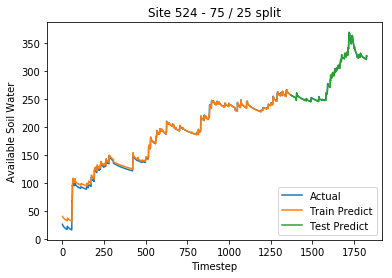

In [16]:
trainPredict = model.predict(trainX1)
testPredict = model.predict(testX1)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY1])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY1])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.xlabel('Timestep')
plt.ylabel('Available Soil Water')
plt.title("Site 524 - 75 / 25 split")
plt.legend(loc=4)

plt.savefig('7525_524.png')
plt.show()

We can cross validate the model by using the other splits that we generated above.

The original split was 75% train / 25% test. The following splits are 67% train / 33% split and 50% train / 50% split.

Train Score: 17.92 RMSE
Test Score: 11.68 RMSE


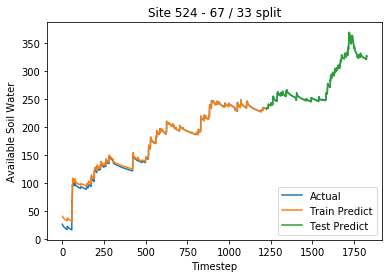

In [17]:
trainPredict = model.predict(trainX2)
testPredict = model.predict(testX2)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY2])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY2])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.xlabel('Timestep')
plt.ylabel('Available Soil Water')
plt.title("Site 524 - 67 / 33 split")
plt.legend(loc=4)
plt.savefig('6733_524.png')
plt.show()

Train Score: 21.57 RMSE
Test Score: 9.19 RMSE


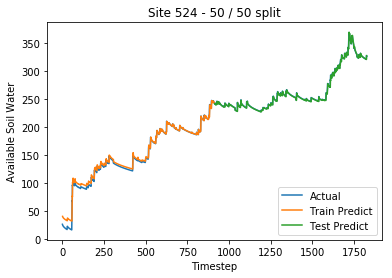

In [18]:
trainPredict = model.predict(trainX3)
testPredict = model.predict(testX3)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY3])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY3])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.xlabel('Timestep')
plt.ylabel('Available Soil Water')
plt.title("Site 524 - 50 / 50 split")
plt.legend(loc=4)
plt.savefig('5050_524.png')
plt.show()

The model is performing very well, all the test scores are 

I will now test the model on a different dataset from the same site, this data is from 2017.

We will set up the data the same as we did for the initial training and testing data above.

273 92
244 121
182 183
Train Score: 7.81 RMSE
Test Score: 5.56 RMSE


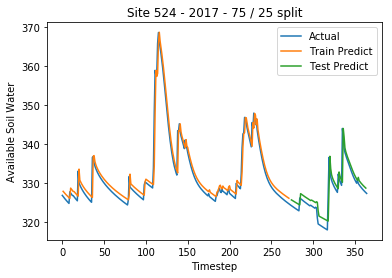

Train Score: 8.38 RMSE
Test Score: 4.84 RMSE


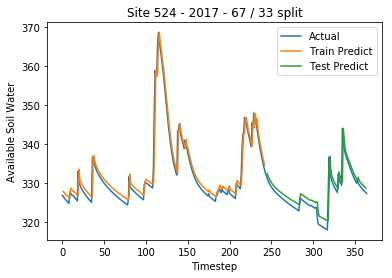

Train Score: 8.68 RMSE
Test Score: 5.58 RMSE


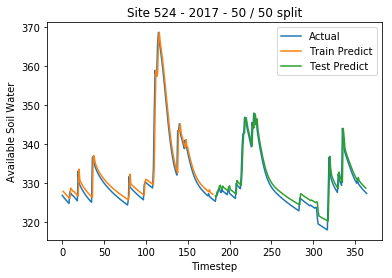

In [19]:
dataframe = pd.read_csv('b524_test.csv', usecols=[1], engine='python')

dataset = dataframe.values
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train1, test1 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train1), len(test1))

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train2, test2 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train2), len(test2))

train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train3, test3 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train3), len(test3))

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.roll(np.array(dataY),-7)

look_back = 1

trainX1, trainY1 = create_dataset(train1, look_back)
testX1, testY1 = create_dataset(test1, look_back)

trainX2, trainY2 = create_dataset(train2, look_back)
testX2, testY2 = create_dataset(test2, look_back)

trainX3, trainY3 = create_dataset(train3, look_back)
testX3, testY3 = create_dataset(test3, look_back)

trainX1 = np.reshape(trainX1, (trainX1.shape[0], 1, trainX1.shape[1]))
testX1 = np.reshape(testX1, (testX1.shape[0], 1, testX1.shape[1]))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], 1, trainX2.shape[1]))
testX2 = np.reshape(testX2, (testX2.shape[0], 1, testX2.shape[1]))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], 1, trainX3.shape[1]))
testX3 = np.reshape(testX3, (testX3.shape[0], 1, testX3.shape[1]))

trainPredict = model.predict(trainX1)
testPredict = model.predict(testX1)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY1])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY1])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.xlabel('Timestep')
plt.ylabel('Available Soil Water')
plt.title("Site 524 - 2017 - 75 / 25 split")
plt.legend()
plt.savefig('7525_524a.png')
plt.show()

trainPredict = model.predict(trainX2)
testPredict = model.predict(testX2)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY2])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY2])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.xlabel('Timestep')
plt.ylabel('Available Soil Water')
plt.title("Site 524 - 2017 - 67 / 33 split")
plt.legend()
plt.savefig('6733_524a.png')
plt.show()

trainPredict = model.predict(trainX3)
testPredict = model.predict(testX3)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY3])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY3])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.xlabel('Timestep')
plt.ylabel('Available Soil Water')
plt.title("Site 524 - 2017 - 50 / 50 split")
plt.legend()
plt.savefig('5050_524a.png')
plt.show()

The model still performs very well on data it has never seen before

1370 457
1224 603
913 914
Train Score: 11.17 RMSE
Test Score: 9.22 RMSE


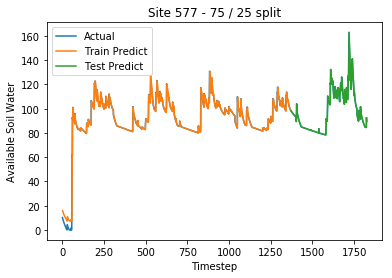

Train Score: 10.85 RMSE
Test Score: 8.62 RMSE


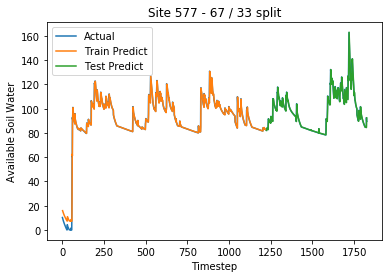

Train Score: 13.65 RMSE
Test Score: 7.62 RMSE


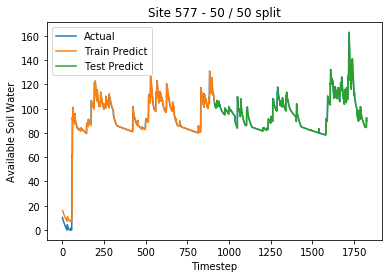

In [20]:
dataframe = pd.read_csv('b577_train.csv', usecols=[1], engine='python')

dataset = dataframe.values
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train1, test1 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train1), len(test1))

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train2, test2 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train2), len(test2))

train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train3, test3 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train3), len(test3))

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.roll(np.array(dataY),-7)

look_back = 1

trainX1, trainY1 = create_dataset(train1, look_back)
testX1, testY1 = create_dataset(test1, look_back)

trainX2, trainY2 = create_dataset(train2, look_back)
testX2, testY2 = create_dataset(test2, look_back)

trainX3, trainY3 = create_dataset(train3, look_back)
testX3, testY3 = create_dataset(test3, look_back)

trainX1 = np.reshape(trainX1, (trainX1.shape[0], 1, trainX1.shape[1]))
testX1 = np.reshape(testX1, (testX1.shape[0], 1, testX1.shape[1]))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], 1, trainX2.shape[1]))
testX2 = np.reshape(testX2, (testX2.shape[0], 1, testX2.shape[1]))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], 1, trainX3.shape[1]))
testX3 = np.reshape(testX3, (testX3.shape[0], 1, testX3.shape[1]))

trainPredict = model.predict(trainX1)
testPredict = model.predict(testX1)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY1])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY1])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.xlabel('Timestep')
plt.ylabel('Available Soil Water')
plt.title("Site 577 - 75 / 25 split")
plt.legend()
plt.savefig('7525_577.png')
plt.show()

trainPredict = model.predict(trainX2)
testPredict = model.predict(testX2)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY2])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY2])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.xlabel('Timestep')
plt.ylabel('Available Soil Water')
plt.title("Site 577 - 67 / 33 split")
plt.legend()
plt.savefig('6733_577.png')
plt.show()

trainPredict = model.predict(trainX3)
testPredict = model.predict(testX3)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY3])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY3])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.xlabel('Timestep')
plt.ylabel('Available Soil Water')
plt.title("Site 577 - 50 / 50 split")
plt.legend()
plt.savefig('5050_577.png')
plt.show()

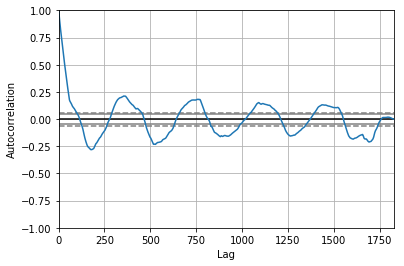

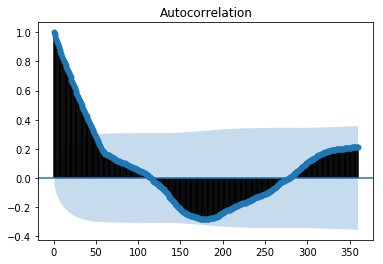

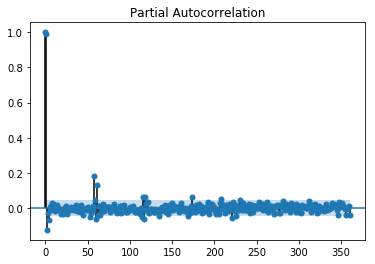

In [21]:
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(pd.Series(dataset[:,0]))
sm.graphics.tsa.plot_acf(dataset, lags=360);
sm.graphics.tsa.plot_pacf(dataset, lags=360);